<a href="https://colab.research.google.com/github/spazznolo/stc-dsf-exam/blob/main/dsf_stc_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ASSIGNMENT 2: NATURAL DISASTERS DATASET**

The objective of this assignment is to build a model which classifies tweets as either being about a real disaster or not. In particular, we're looking for the most simple model which "gets the job done", while also being interpretable. In total, three models will be attempted -  a bag of words model, another using tf-idf in combination with a traditional ML learning algorithm, and then a pre-trained word/sentence embedder in combination with a linear classifier. Though the guidelines are extensive, there is still room for further decision making based on the project and data at hand. In order to make these decisions, we first need to explore the dataset. The exploratory data analysis is outlined below, along with the loading of necessary modules.

In [85]:
# Load data manipulation modules
import pandas as pd
import numpy as np

# Load data visualization modules
import matplotlib.pyplot as plt

# Load text manipulation modules
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load machine learning modules
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

# Load pre-trained word embedding modules
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

# Load datset
train = pd.read_csv('train.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Exploring the Dataset**

The exploration will be sumarized in bullet points due to the time limit of the assignment.

*   The test set has no labels, thus only the train set is used. 
*   The train data contains 7608 Tweets (observations).
*   42.9% of these Tweets are from real disasters, while 57.1% are not (the dataset is well balanced).
*   Aside from the Tweet, there is information on the user's location and the Tweet's keyword has been provided (though it is unlcear where it comes from).
*   Because of the above point, we can use metrics like accuracy and AUC to determine model performance.
*   There are no Tweets with missing fields, but 33.2% of Tweets are without user location and 0.8% of Tweets are without a keyword.
*   Certain symbols seem to have been obfuscate/lost during the encoding of the Tweets.

## **Contextualizing Tweets**
Twitter is a popular social media app which comes with its own stylistic form. For example, it is common on twitter to "mention" another user through the form of "@username". It is also common to include a Tweet as part of a larger conversation through the form of "hastags" (#trending). Also, it is common for users to share links to videos, articles, etc. (here, the tweet would include http...).



In [86]:
train.isnull().mean(axis = 0)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [87]:
train['target'].mean()

0.4296597924602653

In [88]:
# Create the predictor set and the target vector
X = train.drop(['target'], axis=1)
y = train['target']

# Randomly split the model set into training (75%) and validation (25%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=33)

In [89]:
# Assign stemmer to object
ps = PorterStemmer()

# Function which preprocesses text in general format for all models
def preprocess_text(text):

    # removes encoding quirks
    text = re.sub(r'&[a-zA-Z]+;?', '', text)
    # removes mentions
    text = re.sub(r'@[a-zA-Z_]+;?', '', text)
    # removes numbers
    text = re.sub(r'\w*\d+\w*', '', text)
    # make all text lowercase
    text = text.lower()

    # tokenizes text
    text = nltk.word_tokenize(text)
    # removes stop words
    text = [i for i in text if i not in stopwords.words('english')]
    # removes punctuation
    text = [i for i in text if i not in string.punctuation]
    # stems alphanumeric values
    text = [ps.stem(i) for i in text if i.isalnum() == True]
    
    return " ".join(text)


# **Task 1: Bag of words model**

The first model, which is also the simplest, is built through the text processing method called Bag-of-Words, where a given Tweet's words are added up as they occur. For example: 'Michael has the bag and has the cat' would yield a value of 1 for Michael, but 2 for has.

In [90]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))

X_train_vec = vectorizer.fit_transform(X_train['text'].apply(preprocess_text))
X_train_vec = pd.DataFrame(X_train_vec.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train.index)

X_val_vec = vectorizer.transform(X_val['text'].apply(preprocess_text))
X_val_vec = pd.DataFrame(X_val_vec.toarray(), columns=vectorizer.get_feature_names_out(), index=X_val.index)

In [104]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(random_state=33)
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_val_vec)
y_pred_proba = lr.predict_proba(X_val_vec)  

precision_1 = metrics.precision_score(y_val, y_pred)
fscore_1 = metrics.f1_score(y_val, y_pred)
accuracy_1 = metrics.accuracy_score(y_val, y_pred)

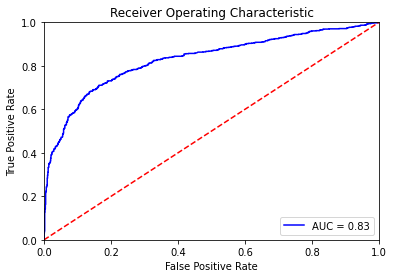

In [105]:
y_pred_proba = y_pred_proba[:,1]
fpr_1, tpr_1, threshold_1 = metrics.roc_curve(y_val, y_pred_proba)
roc_auc_1 = metrics.auc(fpr_1, tpr_1)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_1, tpr_1, 'b', label = 'AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Task 2: Feature generation and traditional ML model**

Now that the basics are covered, we'll test a more modern, complex, and memory-intensive approach. This will be done by first processing the data through a Term Frequency - Inverse Document Frequency (tf-idf) vectorizer.

In [93]:
# instantiate the vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')

# fit and transform
X_train_tfidf = tfidf.fit_transform(X_train['text'].apply(preprocess_text))
X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf.get_feature_names_out(), index=X_train.index)

# fit and transform
X_val_tfidf = tfidf.transform(X_val['text'].apply(preprocess_text))
X_val_tfidf = pd.DataFrame(X_val_tfidf.toarray(), columns = tfidf.get_feature_names_out(), index=X_val.index)

### **Mining Other Predictors**

Twitter is used for a wide variety of purposes. It is used to disseminate official information to the populace, to debate and discuss rapidly evolving news stories, for the creation/dissemination of art, for entertainment among friends. Through all of these use case, the communication tends to have unique stylistic choices. As an example, official information maybe be written more formally, with care taken to follow linguistic conventions, whereas informal communication among friends maybe be shorter and less conventional. It is along these lines of thought that the following predictors were created.


*   Tweet length (number of characters in Tweet)
*   Average Word Length (not counting stop words)
*   Location (binary, location of person when they Tweeted)
*   Keyword (binary, seems to be pulled directly from tweet)
*   Link Shared (binary)




In [94]:
X_train_tfidf['keyword_binary'] = np.where(X_train['keyword'].isnull(), 0, 1)
X_val_tfidf['keyword_binary'] = np.where(X_val['keyword'].isnull(), 0, 1)

X_train_tfidf['location_binary'] = np.where(X_train['location'].isnull(), 0, 1)
X_val_tfidf['location_binary'] = np.where(X_val['location'].isnull(), 0, 1)

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

X_train_temp = X_train.copy()
X_val_temp = X_val.copy()

X_train_temp['length'] = X_train['text'].str.len()
X_val_temp['length'] = X_val['text'].str.len()

X_train_temp['words'] = X_train['text'].str.count(' ') + 1
X_val_temp['words'] = X_val['text'].str.count(' ') + 1

X_train_temp['avg_word_length'] = X_train_temp['length']/X_train_temp['words'] 
X_val_temp['avg_word_length'] = X_val_temp['length']/X_val_temp['words'] 

X_train_temp['hash_avg'] = X_train['text'].str.count('#')/X_train_temp['words'] 
X_val_temp['hash_avg'] = X_val['text'].str.count('#')/X_val_temp['words']

X_train_temp['mention_avg'] = X_train['text'].str.count('@')/X_train_temp['words'] 
X_val_temp['mention_avg'] = X_val['text'].str.count('@')/X_val_temp['words']

X_train_temp['upper_avg'] = X_train['text'].str.findall(r'[A-Z]').str.len()/X_train_temp['words'] 
X_val_temp['upper_avg'] = X_val['text'].str.findall(r'[A-Z]').str.len()/X_val_temp['words']

X_train_temp['symbol_avg'] = X_train['text'].str.count(r'[^a-zA-Z0-9 ]')/X_train_temp['length'] 
X_val_temp['symbol_avg'] = X_val['text'].str.count(r'[^a-zA-Z0-9 ]')/X_val_temp['length']

X_train_temp['link_count'] = X_train['text'].str.count('http')
X_val_temp['link_count'] = X_val['text'].str.count('http')

X_train_temp['rt'] = X_train['text'].str.count('RT')
X_val_temp['rt'] = X_val['text'].str.count('RT')

new_predictors = ['length', 'avg_word_length', 'hash_avg', 'mention_avg', 'upper_avg', 'symbol_avg', 'link_count', 'rt']

X_train_temp_scaled = std_scaler.fit_transform(X_train_temp[new_predictors].to_numpy())
X_train_temp_scaled = pd.DataFrame(X_train_temp_scaled, 
                                   columns = new_predictors,
                                   index = X_train_tfidf.index)
X_val_temp_scaled = std_scaler.fit_transform(X_val_temp[new_predictors].to_numpy())
X_val_temp_scaled = pd.DataFrame(X_val_temp_scaled, 
                                 columns = new_predictors,
                                 index = X_val_tfidf.index)

X_train_tfidf = pd.concat([X_train_tfidf, X_train_temp_scaled], axis = 1)
X_val_tfidf = pd.concat([X_val_tfidf, X_val_temp_scaled], axis = 1)


### **Training and evaluating traditional ML model**
Now that the text has been processed using tf-idf, and a handful of other features were derived using our knowledge of Tweets and disasters, we train a traditional ML model with the new model set. Remember, the goal is to determine if a given Tweet is reffering to a real disaster or not - this is a classification problem. Therefore, our choice of learning algorithm is restricted to classifiers. Given the data is high-dimensional, the Support Vector Machine - which handles high-dimensional data well - is used.

In [95]:
# Build and train traditional ML model
svm = LinearSVC(random_state=33, max_iter = 100000)
clf = CalibratedClassifierCV(svm) 
clf.fit(X_train_tfidf, y_train)

# Classify observations in the validation set
y_pred = clf.predict(X_val_tfidf)
y_pred_proba = clf.predict_proba(X_val_tfidf)

# Calculate performance metrics
precision_2 = metrics.precision_score(y_val, y_pred)
fscore_2 = metrics.f1_score(y_val, y_pred)
accuracy_2 = metrics.accuracy_score(y_val, y_pred)

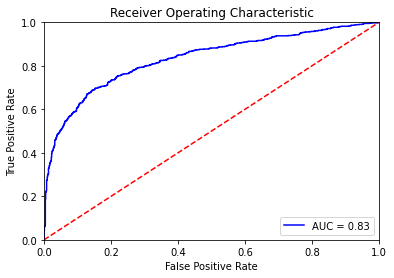

In [96]:
y_pred_proba = y_pred_proba[:,1]
fpr_2, tpr_2, threshold_2 = metrics.roc_curve(y_val, y_pred_proba)
roc_auc_2 = metrics.auc(fpr_2, tpr_2)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_2, tpr_2, 'b', label = 'AUC = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Task 3: Pre-trained word embeddings + linear classifier model**

A pre-trained word embedding is attempts to derive meaning for words and their relationship to eachother in a numerical format. For this problem, I chose the all-MiniLM-L6-v2 pre-trained model from SBERT. It is among the lightest of pre-trained word embeddings while also offering strong performance. It is also a sentence/paragraph embedding. I chose a sentence embedding because we're looking for a single embedding which represents a sequence of words (a Tweet). An efficient way to do this is to consider the Tweet as a sentence/paragraph, and use the sentence embedder. After running the training and validation sets through the pre-trained sentence embedding, there were 384 variables.

In [99]:
# Load the pre-trained sentence embedding: mini-lm 
mini_lm_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode train, validation Tweets with pre-trained embedding
train_embeddings = mini_lm_model.encode(X_train['text'].apply(preprocess_text).tolist())
val_embeddings = mini_lm_model.encode(X_val['text'].apply(preprocess_text).tolist())
print(train_embeddings.shape)

(5709, 384)


In [100]:
# Building, fitting SGD Classifer to newly created training set
sgd = make_pipeline(StandardScaler(), SGDClassifier(loss='hinge', max_iter=10000, random_state=33))
clf = CalibratedClassifierCV(sgd) 
clf.fit(train_embeddings, y_train)

# Classifying validation set with newly trained model
y_pred = clf.predict(val_embeddings)
y_pred_proba = clf.predict_proba(val_embeddings)

# Calculating performance metrics
precision_3 = metrics.precision_score(y_val, y_pred)
fscore_3 = metrics.f1_score(y_val, y_pred)
accuracy_3 = metrics.accuracy_score(y_val, y_pred)

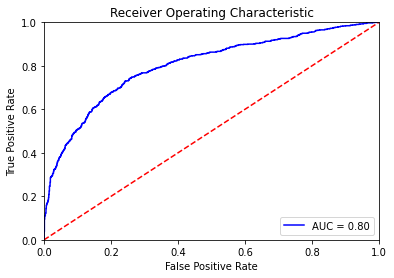

In [101]:
y_pred_proba = y_pred_proba[:,1]
fpr_3, tpr_3, threshold_3 = metrics.roc_curve(y_val, y_pred_proba)
roc_auc_3 = metrics.auc(fpr_3, tpr_3)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_3, tpr_3, 'b', label = 'AUC = %0.2f' % roc_auc_3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **TASK 4 - Recommendations to the clients**

The recommendation to the client is made using the following qualitative and quantitative metrics: simplicity, interpretability, accuracy, AUC, precision, and f1 score. Ultimately, the results point to using the simplest method - the Bag-of-Words model. It has among the highest accuracy and AUC, is the simplest, and the easiest to interpret (after all, the bag of words model uses words without attempting to contextual them. To add context, with the time limit and the constraint on optimization, it isn't surprising that the most simple model was best. However, if both constraints were lifted, it is possible that the other models would have offered enough of an improvement in accuracy and AUC to justify their use.

In [108]:
print(accuracy_1, accuracy_2, accuracy_3)

0.7804621848739496 0.7710084033613446 0.7426470588235294


In [109]:
print(precision_1, precision_2, precision_3)

0.7997159090909091 0.7583120204603581 0.7536231884057971


In [110]:
print(fscore_1, fscore_2, fscore_3)

0.7292746113989638 0.7311960542540075 0.6797385620915033


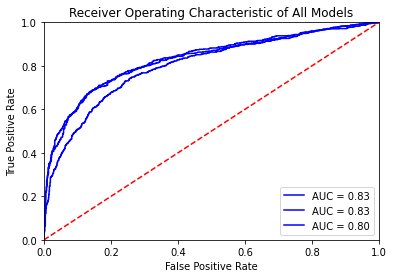

In [111]:
# method I: plt
plt.title('Receiver Operating Characteristic of All Models')
plt.plot(fpr_1, tpr_1, 'b', label = 'AUC = %0.2f' % roc_auc_1)
plt.plot(fpr_2, tpr_2, 'b', label = 'AUC = %0.2f' % roc_auc_2)
plt.plot(fpr_3, tpr_3, 'b', label = 'AUC = %0.2f' % roc_auc_3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()